In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import Grouper
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [ ]:
nifty_df=pd.read_csv("/content/NIFTY PHARMA_Data.csv")

In [ ]:
df = nifty_df.iloc[::-1]

# Reset the index to be in ascending order
df = df.reset_index(drop=True)

# Optionally, if you have a DateTimeIndex, you can also reverse the order of the in
df.index = df.index[::-1]
df.head()


,Date,Open,High,Low,Close
3711,17 Jul 2008,-,-,-,3071.15
3710,18 Jul 2008,-,-,-,3081.31
3709,21 Jul 2008,-,-,-,3194.19
3708,22 Jul 2008,-,-,-,3224.57
3707,23 Jul 2008,-,-,-,3263.38


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [ ]:
df.head()

,Date,Open,High,Low,Close
3711,2008-07-17,-,-,-,3071.15
3710,2008-07-18,-,-,-,3081.31
3709,2008-07-21,-,-,-,3194.19
3708,2008-07-22,-,-,-,3224.57
3707,2008-07-23,-,-,-,3263.38


In [ ]:
df.Date=pd.to_datetime(df.Date,dayfirst=True)

In [ ]:
df_closed=pd.DataFrame(df[['Date','Close']])

In [ ]:
df_closed.set_index('Date', inplace=True)


In [ ]:
df_closed.head()

,Close
Date,
2008-07-17,3071.15
2008-07-18,3081.31
2008-07-21,3194.19
2008-07-22,3224.57
2008-07-23,3263.38


In [ ]:
df_closed=df_closed.asfreq('B')

In [ ]:
df_closed.head()

,Close
Date,
2008-07-17,3071.15
2008-07-18,3081.31
2008-07-21,3194.19
2008-07-22,3224.57
2008-07-23,3263.38


In [ ]:
print(df_closed.isnull().sum())

Close    214
dtype: int64


In [ ]:
df_closed['Close'] = df_closed['Close'].fillna(method = 'ffill')

In [ ]:
fig = px.line(df_closed, x=df_closed.index, y='Close', title='Time Series Plot of Close price of Nifty Pharma stock in INR')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
fig = px.box(df_closed, y="Close",title='Boxplot of Close price of Nifty Pharma Stock price')
fig.show()

In [ ]:
data=df_closed.copy()

In [ ]:
train=pd.DataFrame(data[:int(0.9*len(data))])
test=pd.DataFrame(data[int(0.9*len(data)):])
test.tail()

,Close
Date,
2023-07-10,13751.80
2023-07-11,13895.40
2023-07-12,13936.70
2023-07-13,13876.55
2023-07-14,13945.65


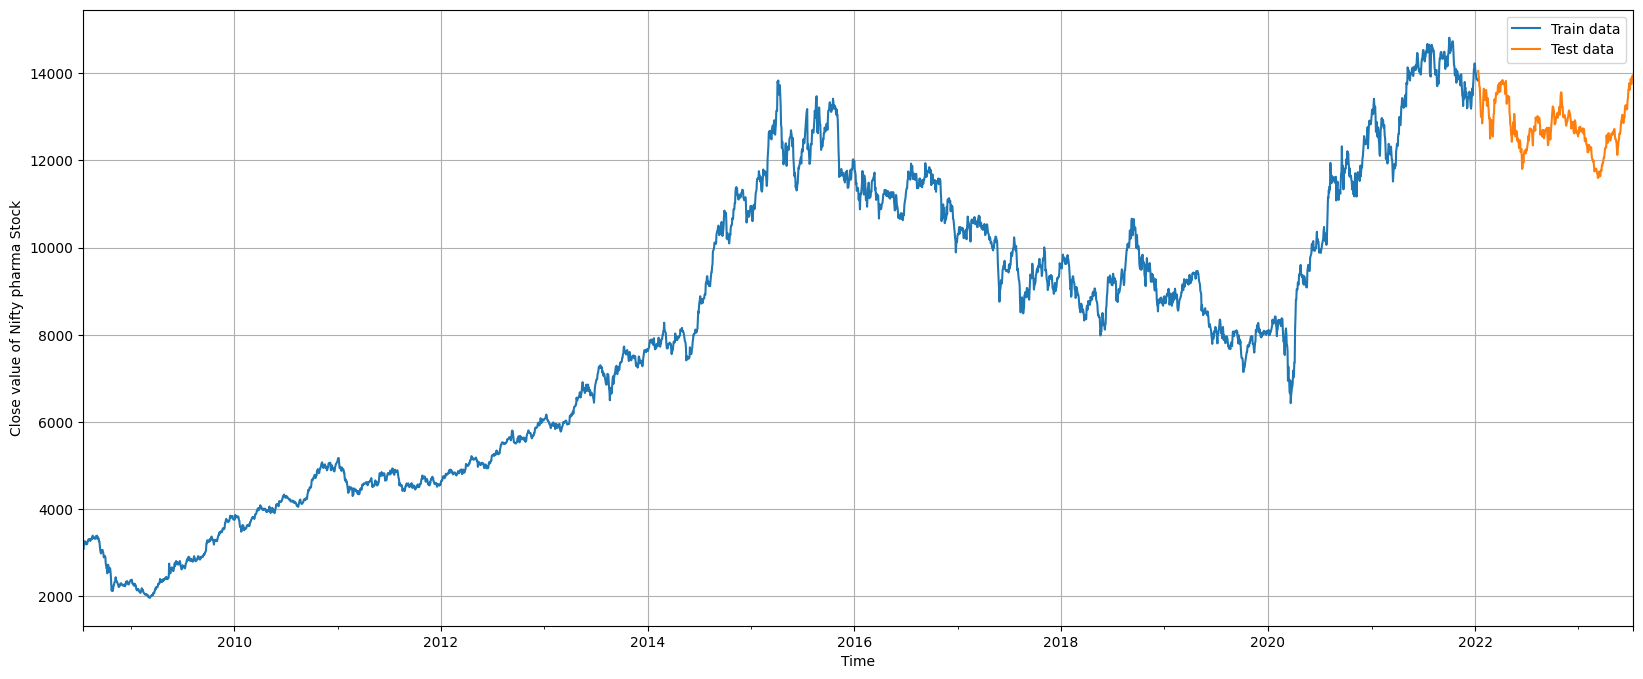

In [ ]:
### Visulaise our data
fig,ax= plt.subplots(figsize=(20,8))
train.plot(kind='line',ax =ax)
test.plot(kind='line',ax =ax)
plt.xlabel('Time')
plt.ylabel("Close value of Nifty pharma Stock")
plt.legend(['Train data','Test data'])
plt.grid()
plt.show()

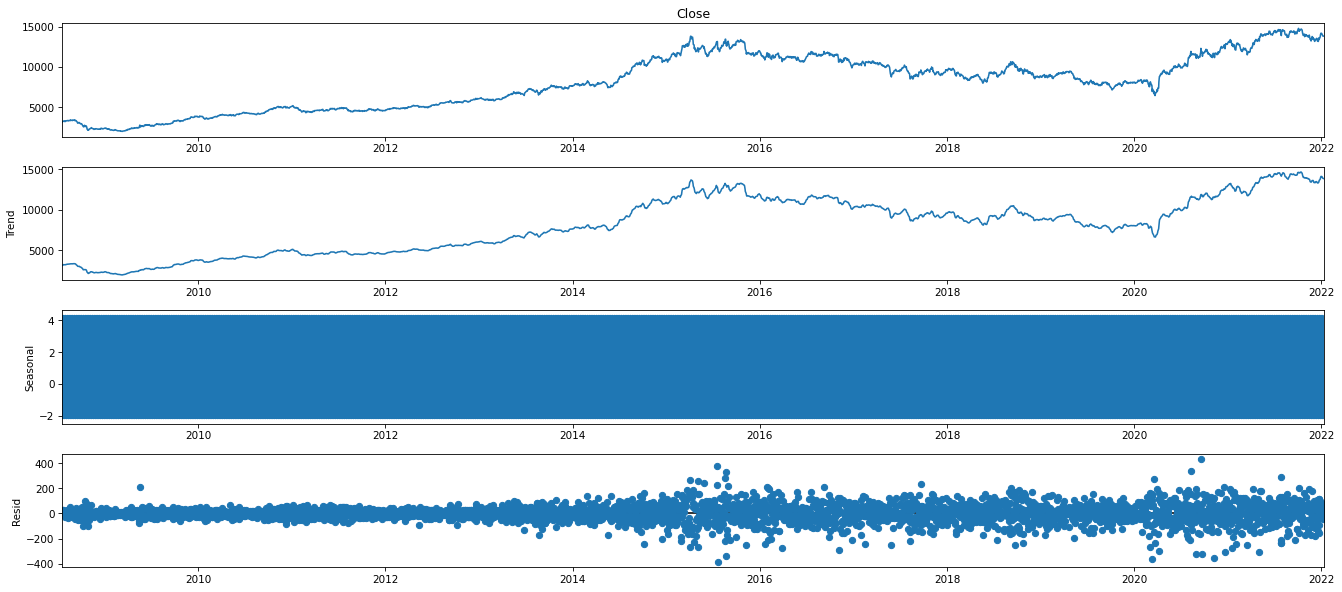

In [ ]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
s_dec_additive = seasonal_decompose(train['Close'],model = "additive")
s_dec_additive.plot()
plt.show()

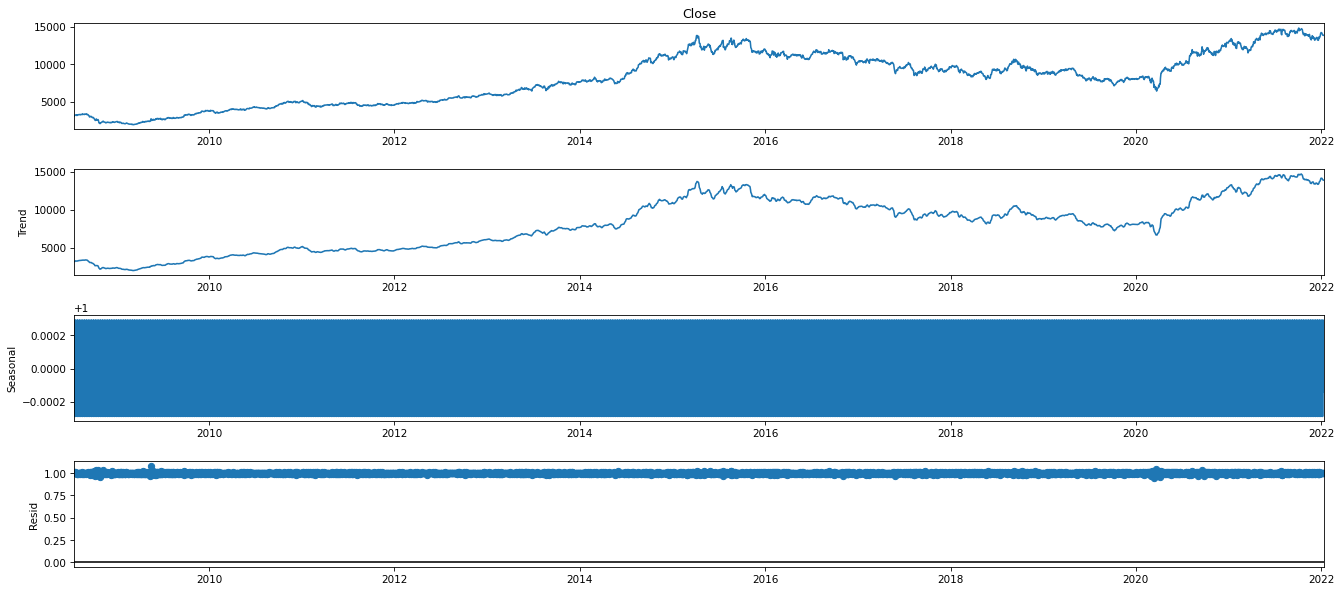

In [ ]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
s_dec_mul = seasonal_decompose(train['Close'],model = "multiplicative")
s_dec_mul.plot()
plt.show()

***As we see from above plots there is some upward ternd present as expected and maybe there is seasonality with almost negligible period respect to number data available. Let's look a more close view.***

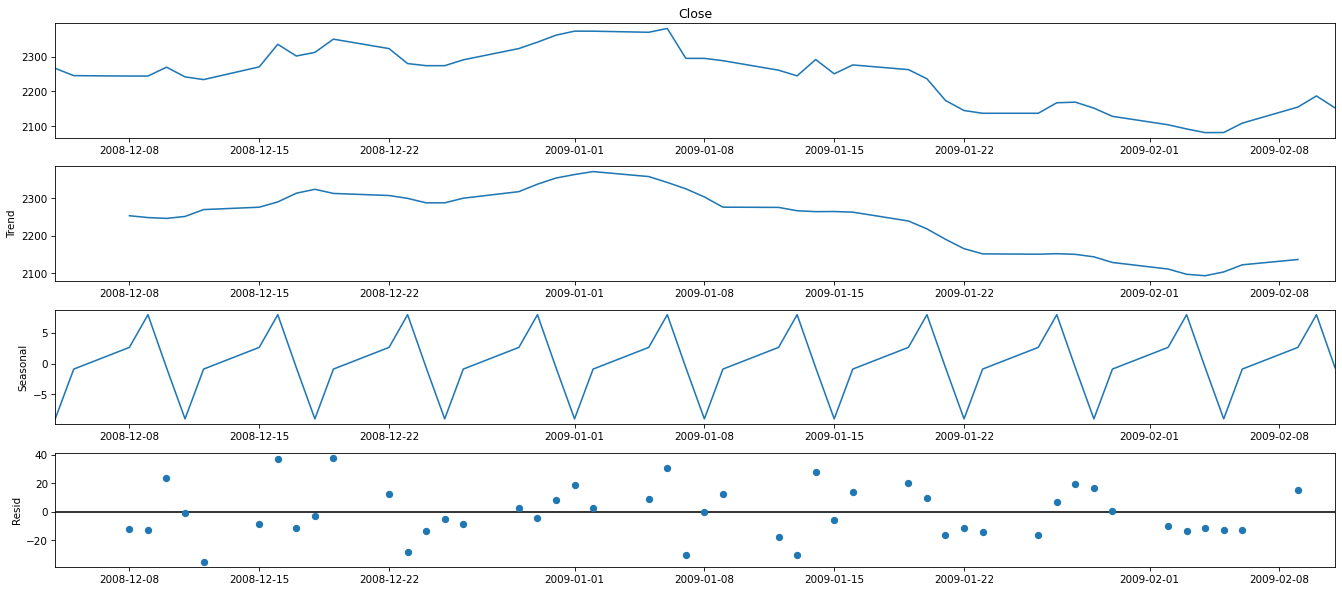

In [ ]:
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':75})
s_dec_mul = seasonal_decompose(train.Close[100:150],model = "additive")
s_dec_mul.plot()
plt.show()

There may be seasonality present with period 8 ( which is very small)

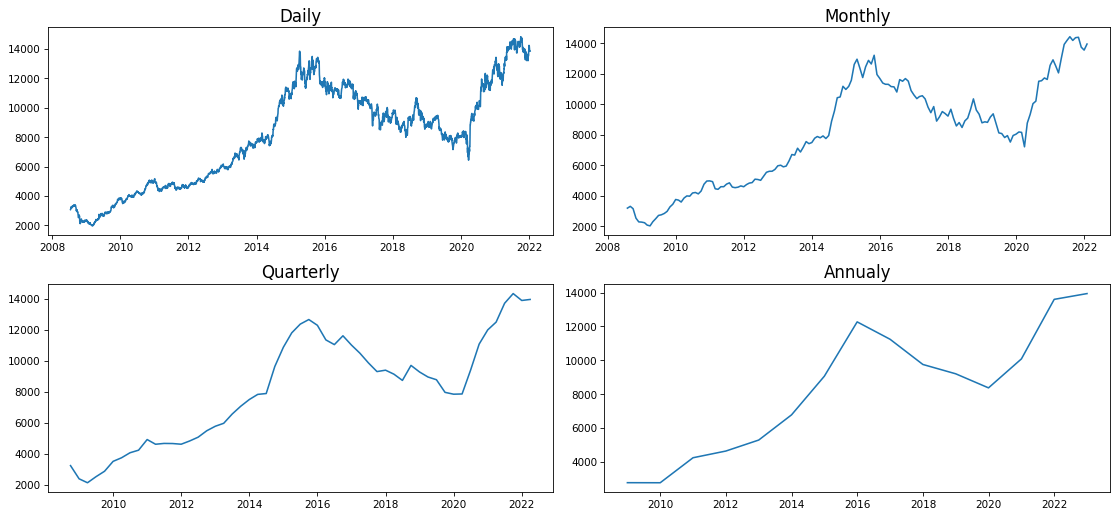

In [ ]:
fig,axes = plt.subplots(2,2,figsize=[15,7])

## resampling to daily freq (original data)
axes[0,0].plot(train.Close)
axes[0,0].set_title("Daily",size=16)

## resampling to monthly freq
axes[0,1].plot(train.Close.resample('M').mean())
axes[0,1].set_title("Monthly",size=16)

## resmapling to quarterly freq
axes[1,0].plot(train.Close.resample('Q').mean())
axes[1,0].set_title('Quarterly',size=16)

## resampling to annualy freq
axes[1,1].plot(train.Close.resample('A').mean())
axes[1,1].set_title('Annualy',size=16)

plt.tight_layout()
plt.show()

**ACF and PACF plots**

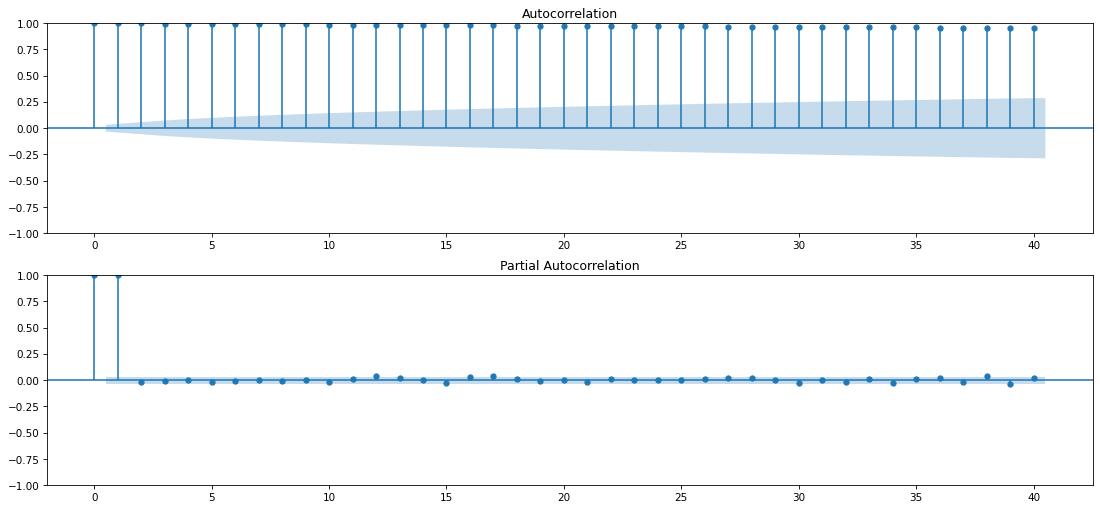

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(train['Close'], lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(train['Close'], lags=40, ax=plt.gca())
plt.show()

****Autocorrelation plot is very slowly decaying and Partial Autocorrelation has a cut-off after lag 1. This implies our data is not stationary. Let's see ACF and PACF plots after applying differencing operator once on the data****

In [ ]:
def difference(dataset,lag):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i]-dataset[i - lag]
        diff.append(value)
    return Series(diff)

In [ ]:
  diff_close=difference(data['Close'],1)

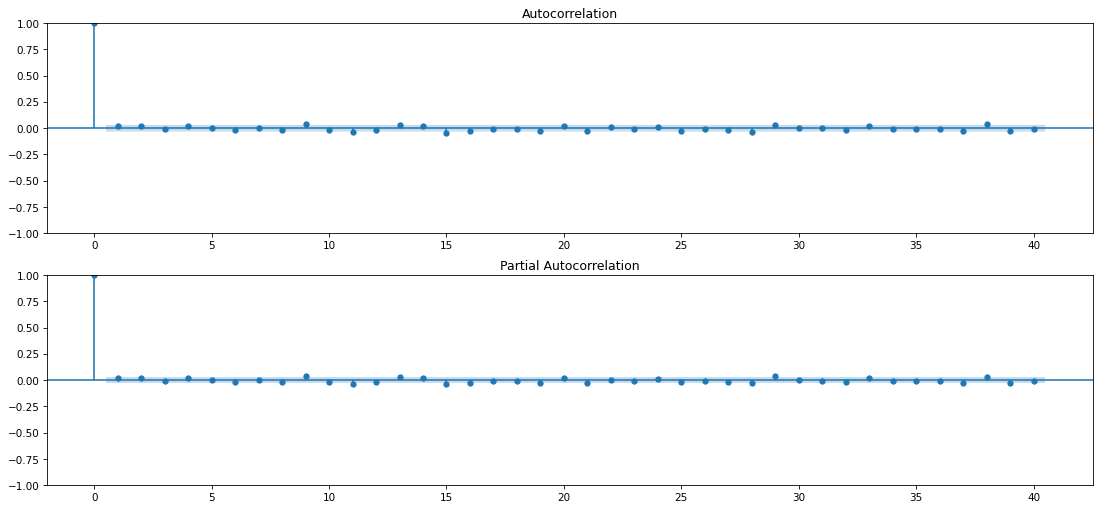

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff_close, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_close, lags=40, ax=plt.gca())
plt.show()

Now, data looks like to be stationary. Let's see what happen if take another differencing



**Now differenciating again*

In [ ]:
diff_close2=difference(diff_close,1)

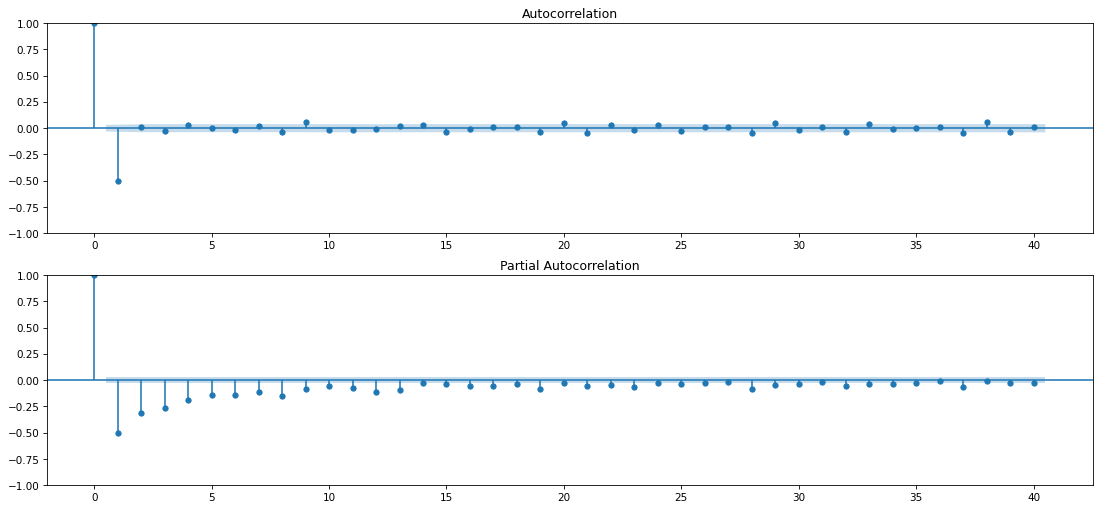

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff_close2, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_close2, lags=40, ax=plt.gca())
plt.show()

####**We have over differenciate. So, d=1 is prefered**

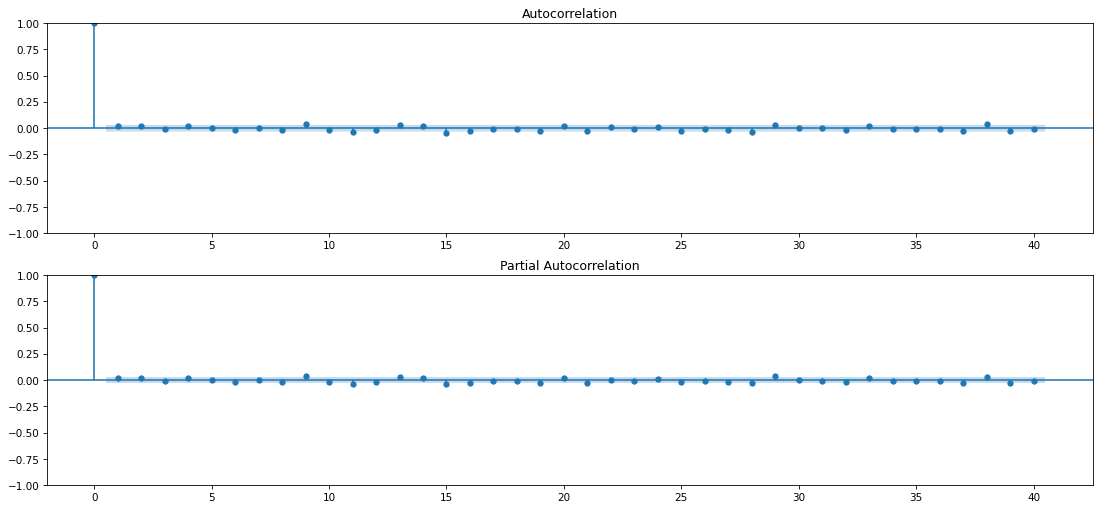

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff_close, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_close, lags=40, ax=plt.gca())
plt.show()

*From this plot we can say p=0 and q=0 was maybe a good intial choices*

######Verify this using ADF test

In [ ]:
result = adfuller(train.Close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.700273
p-value: 0.846679
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


**for d=1 Checking ADF**

In [ ]:
result = adfuller(diff_close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.387397
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


# **ADF test also implies after taking one lag of difference data became stationary. It means d=1 is prefered**

**ARIMA Modeling**

**Modeling ARIMA (0,1,0)**

In [ ]:
train1=train.copy()
test=test.copy()

In [ ]:

import plotly.express as ex
import plotly.graph_objs as go

In [ ]:
diff_sta=data['Close'].diff().dropna()
diff_sta.tail()

Date
2023-07-10    -17.20
2023-07-11    143.60
2023-07-12     41.30
2023-07-13    -60.15
2023-07-14     69.10
Freq: B, Name: Close, dtype: float64

In [ ]:
from datetime import datetime
start_date = datetime.strptime('2022-01-13','%Y-%m-%d')
end_date = datetime.strptime('2023-07-14','%Y-%m-%d')

In [ ]:
start_dat = '2021-10-22'  # start="2021-10-22"
end_dat = '2022-01-15'    # end="2021-12-22"

# Use loc to filter the DataFrame between the two dates
filtered_df = diff_sta.loc[start_dat:end_dat]

In [ ]:
train_non=train.loc[:start_date]

In [ ]:
model1_2 = ARIMA(train_non['Close'], order=(0,1,0))
model_fit1_2 = model1_2.fit()

In [ ]:
fitted_values_non=model_fit1_2.fittedvalues

In [ ]:
model1_1 = ARIMA(filtered_df, order=(0,0,0))
model_fit1_1 = model1_1.fit()
print(model_fit1_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3520
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -21439.010
Date:                Mon, 31 Jul 2023   AIC                          42880.020
Time:                        11:23:45   BIC                          42886.186
Sample:                    07-17-2008   HQIC                         42882.220
                         - 01-12-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.146e+04    126.012     90.938      0.000    1.12e+04    1.17e+04
Ljung-Box (L1) (Q):                   2.03   Jarque-Bera (JB):              8169.94
Prob(Q):                              0.15   Pr

<Figure size 2250x525 with 0 Axes>

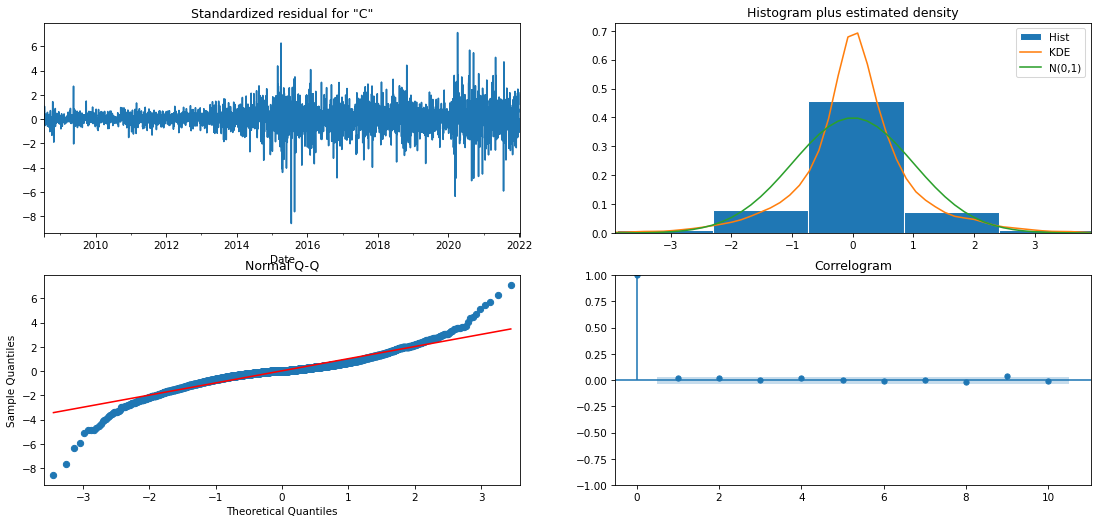

In [ ]:
fig = plt.figure(figsize=(30,7))
fig = model_fit1_2.plot_diagnostics()

In [ ]:
residuals1=model_fit1_1.resid

In [ ]:
aic1=model_fit1_1.aic
bic1=model_fit1_1.bic

In [ ]:
sm.stats.acorr_ljungbox(residuals1, lags=20, return_df=True)

,lb_stat,lb_pvalue
1,0.141995,0.706306
2,0.635601,0.727748
3,0.638373,0.887594
4,0.912477,0.922764
5,1.896064,0.863332
6,4.258770,0.641703
7,4.277073,0.747368
8,5.850191,0.664008
9,6.294437,0.710126
10,9.225479,0.510847


In [ ]:
train1.iloc[-1].values

array([13833.7])

In [ ]:
sd_1 = model_fit1_1.resid.std()
ME_1 = 1.96*sd_1
c2_lower = test['Predicted_Values_ARIMA(0,1,0)']- ME_1
c2_upper = test['Predicted_Values_ARIMA(0,1,0)']+ ME_1

In [ ]:
test['Predicted_Values_ARIMA(0,1,0)'] =train1.iloc[-1].values+np.cumsum(model_fit1_1.predict(start=start_date,end=end_date))

test.tail()

,Close,"Predicted_Values_ARIMA(0,1,0)"
Date,,
2023-07-10,13751.80,12524.723231
2023-07-11,13895.40,12521.349580
2023-07-12,13936.70,12517.975928
2023-07-13,13876.55,12514.602277
2023-07-14,13945.65,12511.228625


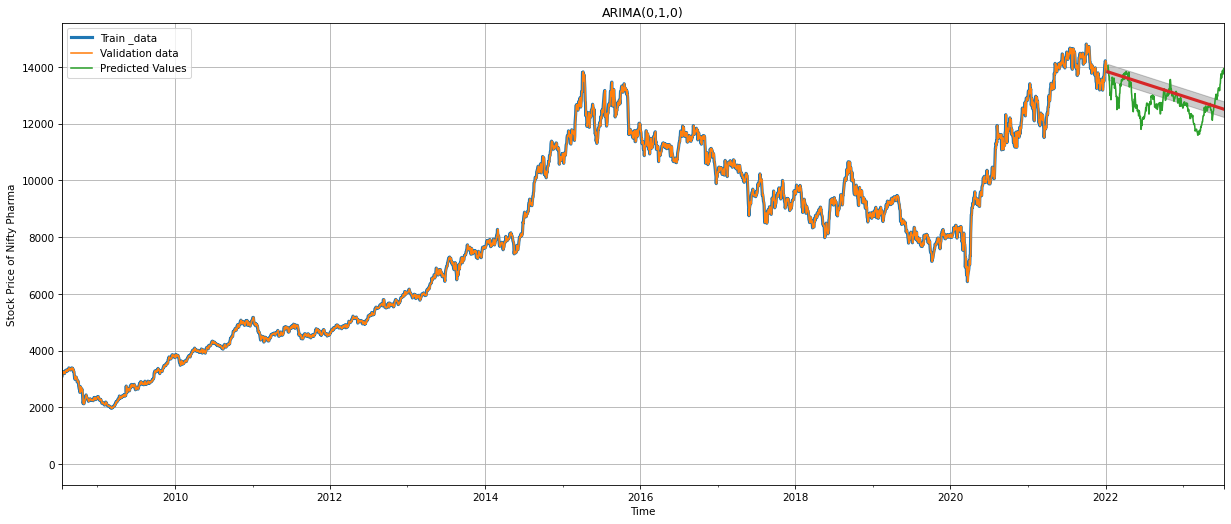

In [ ]:
## Visulaization
fig,ax= plt.subplots(figsize=(20,8))
#train1.plot(kind='line',ax =ax)
train1.plot(kind = 'line',ax =ax,linewidth=3)
fitted_values_non.plot(kind = 'line',ax =ax)
plt.xlabel('Time')
#ARIMA(train1[3460:], order=(0,1,0)).fit().fittedvalues.plot(kind='line',ax =ax)
test['Close'].plot(kind='line',ax =ax)

##
test['Predicted_Values_ARIMA(0,1,0)'].plot(kind='line',linewidth=3,ax=ax)
##
plt.xlabel('Time')
#plt.ylim(10000,15000)
plt.ylabel("Stock Price of Nifty Pharma")
plt.fill_between(test.index, (c2_lower),(c2_upper),alpha=0.2, color = 'black' )
plt.legend(['Train _data','Validation data','Predicted Values'])
plt.title('ARIMA(0,1,0)')
plt.grid()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test['Close'],test['Predicted_Values_ARIMA(0,1,0)'])).round(2)
#MAPE: Mean absoulte percentage error
mape = np.round(np.mean(np.abs(test['Close']-test['Predicted_Values_ARIMA(0,1,0)'])/test['Close'])*100,2)

m1= pd.DataFrame({'Method': ['ARIMA(0,1,0)'], 'RMSE':[rmse], 'MAPE': [mape], 'AIC': [aic1], 'BIC': [bic1]})
#concatenating it to the existing result dataframe
metric_result=m1
metric_result

,Method,RMSE,MAPE,AIC,BIC
0,"ARIMA(0,1,0)",656.34,4.21,779.795865,784.017613


**Let's apply gride search to find best parameters for ARIMA modelling based on AIC, BIC**

In [ ]:
import itertools


# Define the range of values for p, d, and q
p = range(0, 5)  # AR parameter
d = range(0, 2)  # I(d) parameter
q = range(0, 5)  # MA parameter

# Generate all possible combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# Perform grid search
best_aic = float('inf')
best_bic = float('inf')

best_order1 = None
best_order2 = None


for param in pdq:
    try:
        # Fit ARIMA model
        model = sm.tsa.ARIMA(train1['Close'], order=param)
        results = model.fit()

        #forecast=result.forecast(591)
        # Calculate AIC and BIC
        aic = results.aic
        bic = results.bic
        # Check if the current model has lower AIC or BIC than the best model so far
        if aic < best_aic:
            best_aic = aic
            best_order1 = param
        if bic < best_bic:
            best_bic=bic
            best_order2= param


    except Exception as e:
        continue

# Print the best model's parameters, AIC, and BIC
print("Best AIC:", best_aic)
print("Best ARIMA wrt AIC :", best_order1)
print("Best BIC:", best_bic)
print("Best ARIMA wrt BIC :",best_order2)

KeyboardInterrupt: ignored

## Model2

**ARIMA(4,1,3)**

In [ ]:
train2=train.copy()
test2=test.copy()

In [ ]:
model2_2 = ARIMA(train_non['Close'], order=(4,0,3))
model_fit2_2 = model2_2.fit()

In [ ]:
fitted2_values_non=model_fit2_2.fittedvalues

In [ ]:
model2_1= ARIMA(filtered_df, order=(4,1,3))
model_fit2_1 = model2_1.fit()
print(model_fit2_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   61
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -382.712
Date:                Mon, 31 Jul 2023   AIC                            781.425
Time:                        11:25:16   BIC                            798.180
Sample:                    10-22-2021   HQIC                           787.979
                         - 01-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6253      0.294     -5.528      0.000      -2.202      -1.049
ar.L2         -1.0643      0.410     -2.596      0.009      -1.868      -0.261
ar.L3         -0.2292      0.403     -0.569      0.5

In [ ]:
residuals2=model_fit2_1.resid

In [ ]:
aic1=model_fit2_1.aic
bic1=model_fit2_1.bic

In [ ]:

sm.stats.acorr_ljungbox(residuals2, lags=20, return_df=True)

,lb_stat,lb_pvalue
1,0.160437,0.688754
2,0.221037,0.895370
3,0.226990,0.973119
4,0.407983,0.981818
5,2.014878,0.847083
6,4.235596,0.644828
7,4.444380,0.727404
8,5.264530,0.728965
9,5.271653,0.810014
10,7.075978,0.718253


<Figure size 2250x525 with 0 Axes>

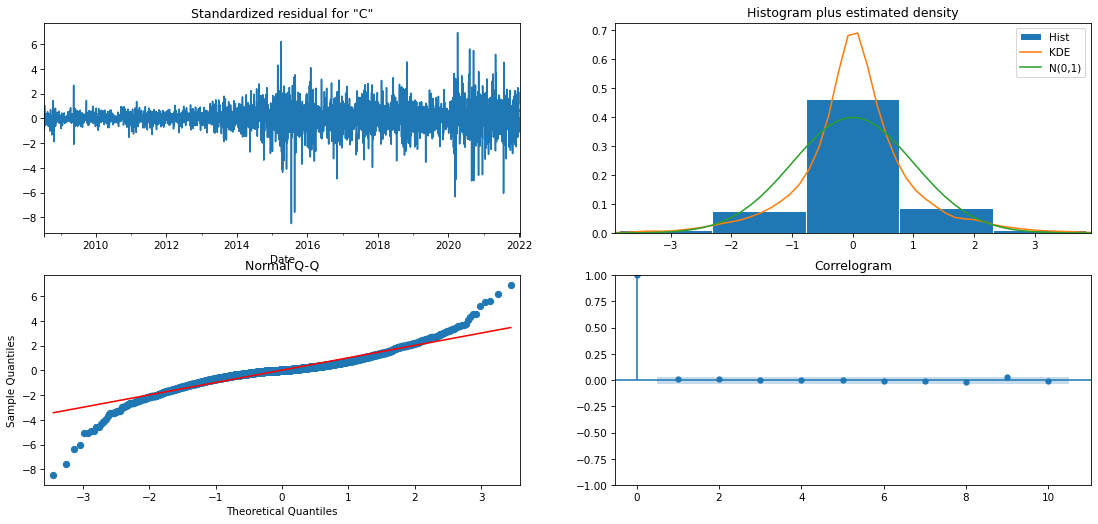

In [ ]:
fig = plt.figure(figsize=(30,7))
fig = model_fit2_2.plot_diagnostics()


In [ ]:
train1.iloc[-1].values

array([13833.7])

In [ ]:

test['Predicted_Values_ARIMA(4,1,3)'] =train1.iloc[-1].values+np.cumsum(model_fit2_1.predict(start=start_date,end=end_date))
test.tail()

,Close,"Predicted_Values_ARIMA(0,1,0)","Predicted_Values_ARIMA(4,1,3)"
Date,,,
2023-07-10,13751.80,12524.723231,12791.230493
2023-07-11,13895.40,12521.349580,12788.575661
2023-07-12,13936.70,12517.975928,12785.931863
2023-07-13,13876.55,12514.602277,12783.282196
2023-07-14,13945.65,12511.228625,12780.631679


In [ ]:
sd = model_fit2_2.resid.std()
ME = 1.96*sd
ME
sd

136.1469756213507

In [ ]:
c1_lower = test['Predicted_Values_ARIMA(4,1,3)']- ME
c1_upper = test['Predicted_Values_ARIMA(4,1,3)']+ ME
test.index

DatetimeIndex(['2022-01-13', '2022-01-14', '2022-01-17', '2022-01-18',
               '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-24',
               '2022-01-25', '2022-01-26',
               ...
               '2023-07-03', '2023-07-04', '2023-07-05', '2023-07-06',
               '2023-07-07', '2023-07-10', '2023-07-11', '2023-07-12',
               '2023-07-13', '2023-07-14'],
              dtype='datetime64[ns]', name='Date', length=392, freq='B')

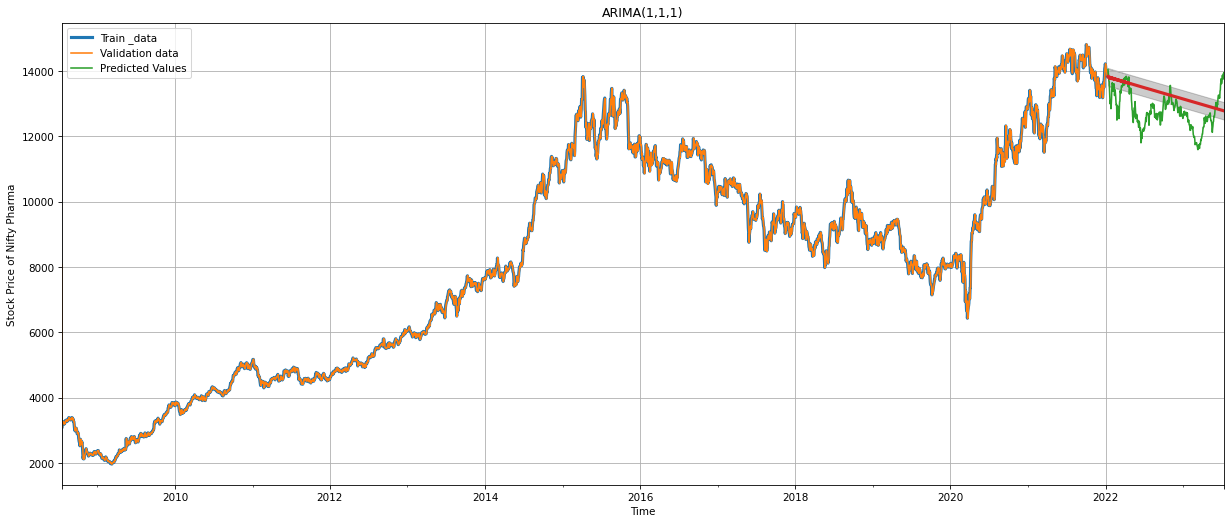

In [ ]:
## Visulaization
fig,ax= plt.subplots(figsize=(20,8))
#train1.plot(kind='line',ax =ax)
train2.plot(kind = 'line',ax =ax,linewidth=3)
fitted2_values_non.plot(kind = 'line',ax =ax)
plt.xlabel('Time')
#ARIMA(train1[3460:], order=(0,1,0)).fit().fittedvalues.plot(kind='line',ax =ax)
test['Close'].plot(kind='line',ax =ax)

##
test['Predicted_Values_ARIMA(4,1,3)'].plot(kind='line',linewidth=3,ax=ax)
##
plt.xlabel('Time')
#plt.ylim(10000,15000)
plt.ylabel("Stock Price of Nifty Pharma")
plt.fill_between(test.index, (c1_lower),(c1_upper),alpha=0.2, color = 'black' )
plt.legend(['Train _data','Validation data','Predicted Values'])
plt.title('ARIMA(1,1,1)')
plt.grid()
plt.show()

#SARIMA gride search

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
diff_close_sarima=diff_close.diff(7).dropna()

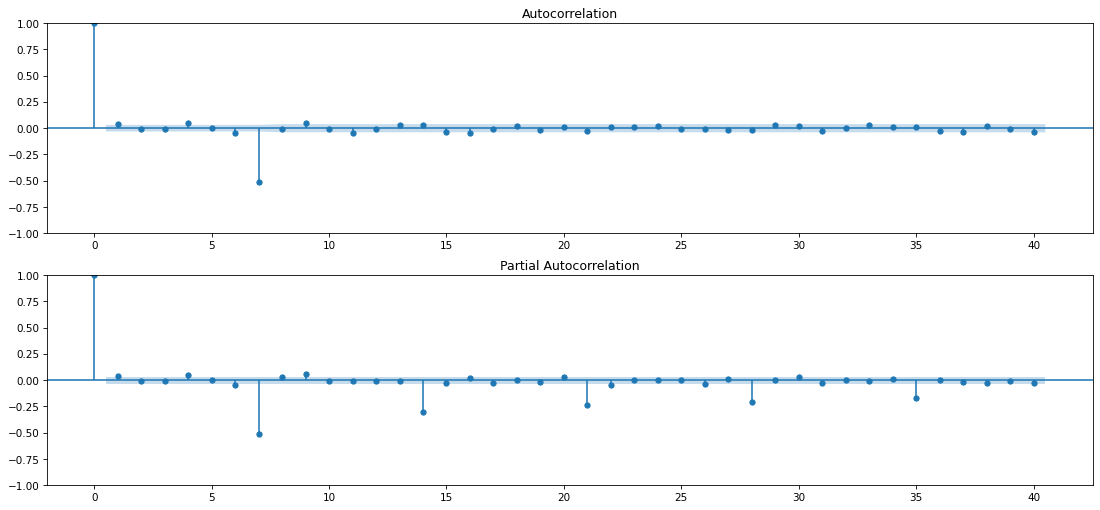

In [ ]:
plt.figure(figsize = (18,8))
plt.subplot(211)
plot_acf(diff_close_sarima, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_close_sarima, lags=40, ax=plt.gca())
plt.show()

In [ ]:
result = adfuller(diff_close_sarima)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.941259
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [ ]:
#SARIMA(0,1,0)[0,1,1][7]

In [ ]:
modle_auto_s=auto_arima(train['Close'],start_p=0,d=1,start_q=0,
                  max_p=4,max_d=1,max_q=4,start_P=0,D=1,start_Q=0,
                  max_P=4,max_D=1,max_Q=4,m=7,seasonal=True,
                  error_action='warn',trace=True,supress_warnings=True,
                  stepwise=True,random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=45226.226, Time=0.46 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=44153.118, Time=3.23 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=6.97 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=45223.012, Time=1.11 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=43831.203, Time=7.43 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=43646.584, Time=10.33 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=43497.029, Time=11.21 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=inf, Time=31.22 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=20.17 sec
 ARIMA(0,1,0)(4,1,0)[7]             : AIC=43496.913, Time=2.60 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=43646.251, Time=1.66 sec
 ARIMA(0,1,0)(4,1,1)[7]             : AIC=inf, Time=34.17 sec
 ARIMA(0,1,0)(3,1,1)[7]             : AIC=inf, Time=18.71 sec
 ARIMA(0,1,1)(4,1,0)[7]             : AIC=43497.122, Time=7.11 sec
 ARIMA(1,1,1)(4,1,0)[7]             : AIC=i

In [ ]:
train_s=train.copy()
test_s=test.copy()

In [ ]:
start="2021-10-22"
end="2021-12-22"
filtered_sarima = diff_sta.loc[start:end]
filtered_sarima_new=diff_close_sarima.loc[start:end]
train_sarima=train.loc[:start]
#model3_2 = ARIMA(train_sarima['Close'], order=(0,1,0))
#model_fit3_2 = model3_2.fit()
#fitted_values_sarima=model_fit3_2.fittedvalues
#model3_1 = ARIMA(filtered_sarima, order=(0,0,0))
#model_fit3_1 = model3_1.fit()
#print(model_fit1_3.summary())

In [ ]:
train_non

,Close
Date,
2008-07-17,3071.15
2008-07-18,3081.31
2008-07-21,3194.19
2008-07-22,3224.57
2008-07-23,3263.38
...,...
2022-01-06,13912.25
2022-01-07,13857.95
2022-01-10,13858.95


In [ ]:
model4_2 = SARIMAX(train_non['Close'], order=(1,1,0),seasonal_order=(0,1,1,7))
model_fit4_2 = model4_2.fit()
print(model_fit4_2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 3520
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood              -21418.073
Date:                             Mon, 31 Jul 2023   AIC                          42842.147
Time:                                     11:30:46   BIC                          42860.639
Sample:                                 07-17-2008   HQIC                         42848.745
                                      - 01-12-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0243      0.012      2.098      0.036       0.002       0.047
ma.S.L7       -0.9993      

In [ ]:
fitted4_values_non=model_fit4_2.fittedvalues

In [ ]:
filtered_sarima_new

Series([], dtype: float64)

In [ ]:
model4_1= SARIMAX(filtered_sarima, order=(1,0,0), seasonal_order=(1,0,0,7))
model_fit4_1 = model4_1.fit()
print(model_fit4_1.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood                -281.479
Date:                           Mon, 31 Jul 2023   AIC                            568.958
Time:                                   11:30:46   BIC                            574.310
Sample:                               10-22-2021   HQIC                           570.943
                                    - 12-22-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1071      0.195     -0.549      0.583      -0.489       0.275
ar.S.L7        0.0573      0.194      0.295

In [ ]:
model_fit4_1.predict(start=start,end=end_date)

2021-10-22    0.000000e+00
2021-10-25    2.358827e+01
2021-10-26    6.212018e-01
2021-10-27   -2.871210e+00
2021-10-28   -1.321896e+01
                  ...     
2023-07-10   -1.551801e-70
2023-07-11   -4.427228e-71
2023-07-12    9.406631e-71
2023-07-13    2.531669e-70
2023-07-14   -1.935011e-71
Freq: B, Name: predicted_mean, Length: 451, dtype: float64

<Figure size 2250x525 with 0 Axes>

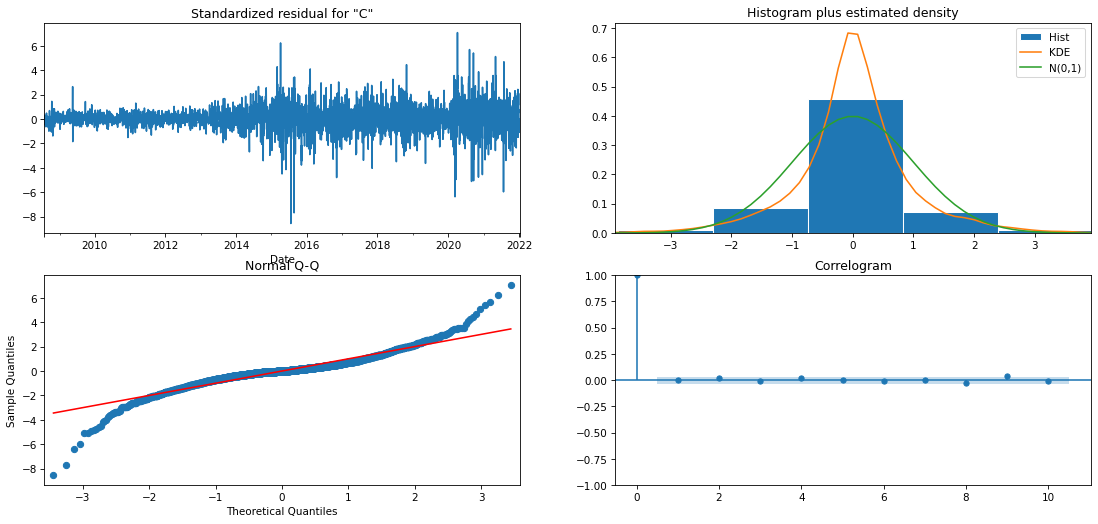

In [ ]:
fig = plt.figure(figsize=(30,7))
fig = model_fit4_2.plot_diagnostics()

In [ ]:
test['Predicted_Values_SARIMA(0,1,0)[0,1,1][7]'] =train_sarima.iloc[-1].values+np.cumsum(model_fit4_1.predict(start=start,end=end_date))
test

,Close,"Predicted_Values_ARIMA(0,1,0)","Predicted_Values_ARIMA(4,1,3)","Predicted_Values_SARIMA(0,1,0)[0,1,1][7]"
Date,,,,
2022-01-13,14051.15,13830.326349,13833.032397,13979.085522
2022-01-14,13964.15,13826.952697,13822.829464,13979.062156
2022-01-17,13862.45,13823.579046,13814.751360,13979.031587
2022-01-18,13697.60,13820.205394,13789.201369,13979.022866
2022-01-19,13682.70,13816.831743,13816.190668,13979.041396
...,...,...,...,...
2023-07-10,13751.80,12524.723231,12791.230493,13979.087450
2023-07-11,13895.40,12521.349580,12788.575661,13979.087450
2023-07-12,13936.70,12517.975928,12785.931863,13979.087450


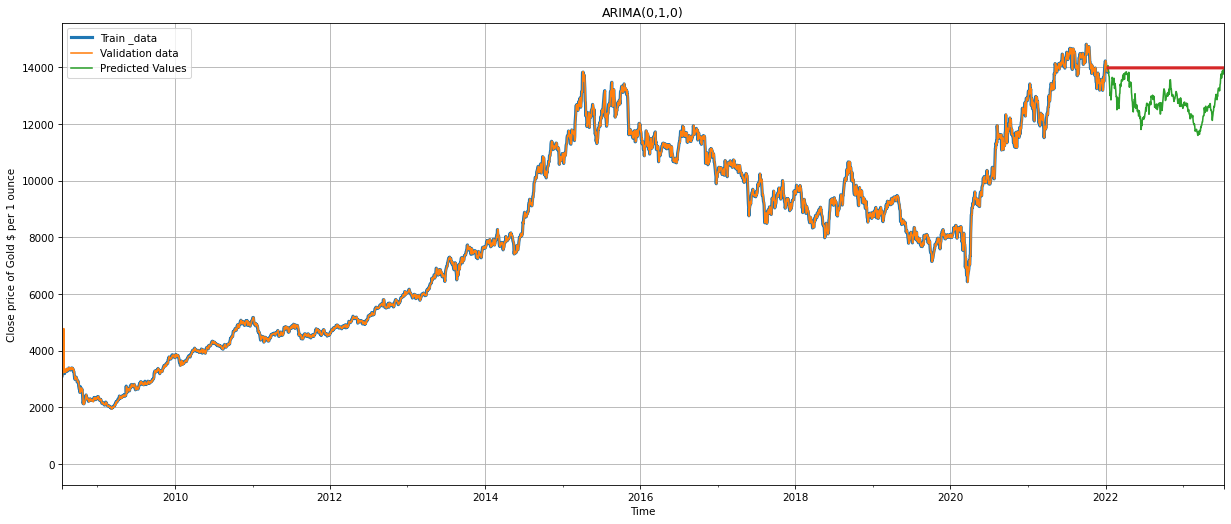

In [ ]:
## Visulaization
fig,ax= plt.subplots(figsize=(20,8))
#train1.plot(kind='line',ax =ax)
train2.plot(kind = 'line',ax =ax,linewidth=3)
fitted4_values_non.plot(kind = 'line',ax =ax)
plt.xlabel('Time')
#ARIMA(train1[3460:], order=(0,1,0)).fit().fittedvalues.plot(kind='line',ax =ax)
test['Close'].plot(kind='line',ax =ax)

##
test['Predicted_Values_SARIMA(0,1,0)[0,1,1][7]'].plot(kind='line',linewidth=3,ax=ax)
##
plt.xlabel('Time')
#plt.ylim(10000,15000)
#plt.fill_between(test.index, (c3_lower),(c3_upper),alpha=0.15, color = 'black' )
plt.ylabel("Close price of Gold $ per 1 ounce")
plt.legend(['Train _data','Validation data','Predicted Values'])
plt.title('ARIMA(0,1,0)')
plt.grid()
plt.show()

In [ ]:
model3_2 = SARIMAX(train_non['Close'], order=(1,1,0),seasonal_order=(5,1,0,8))
model_fit3_2 = model3_2.fit()

In [ ]:
fitted3_values_non=model_fit3_2.fittedvalues

In [ ]:
model3_1= SARIMAX(filtered_sarima, order=(1,0,0), seasonal_order=(5,0,0,8))
model_fit3_1 = model3_1.fit()
print(model_fit3_1.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(5, 0, 0, 8)   Log Likelihood                -278.594
Date:                           Mon, 31 Jul 2023   AIC                            571.189
Time:                                   11:31:14   BIC                            583.678
Sample:                               10-22-2021   HQIC                           575.820
                                    - 12-22-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1442      0.195     -0.739      0.460      -0.526       0.238
ar.S.L8        0.2258      0.621      0.363

<Figure size 2250x525 with 0 Axes>

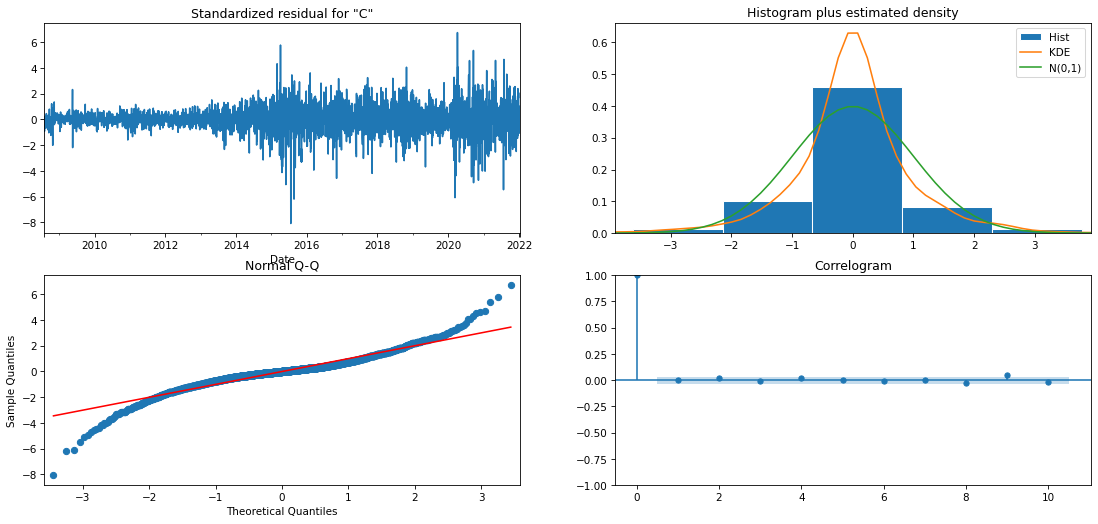

In [ ]:
fig = plt.figure(figsize=(30,7))
fig = model_fit3_2.plot_diagnostics()

In [ ]:
aic1=model_fit3_1.aic
bic1=model_fit3_1.bic
residuals3=model_fit3_1.resid

In [ ]:
sm.stats.acorr_ljungbox(residuals3, lags=20, return_df=True)

,lb_stat,lb_pvalue
1,0.440986,0.506647
2,2.552051,0.279145
3,2.696229,0.440869
4,2.771213,0.596812
5,4.469695,0.483948
6,7.788951,0.253977
7,7.848751,0.346120
8,7.937769,0.439573
9,8.526157,0.482111
10,12.296432,0.265707


In [ ]:
model_fit3_1.predict(start=start,end=end_date)

2021-10-22     0.000000
2021-10-25    31.763433
2021-10-26     0.836207
2021-10-27    -3.863735
2021-10-28   -17.823454
                ...    
2023-07-10   -41.581648
2023-07-11     6.559184
2023-07-12    41.106612
2023-07-13   -14.184466
2023-07-14   -25.070275
Freq: B, Name: predicted_mean, Length: 451, dtype: float64

In [ ]:
test['Predicted_Values_SARIMA'] =train_sarima.iloc[-1].values+np.cumsum(model_fit3_1.predict(start=start,end=end_date))
test.head(5)

,Close,"Predicted_Values_ARIMA(0,1,0)","Predicted_Values_ARIMA(4,1,3)","Predicted_Values_SARIMA(0,1,0)[0,1,1][7]",Predicted_Values_SARIMA
Date,,,,,
2022-01-13,14051.15,13830.326349,13833.032397,13979.085522,13746.083025
2022-01-14,13964.15,13826.952697,13822.829464,13979.062156,13820.938202
2022-01-17,13862.45,13823.579046,13814.751360,13979.031587,13618.308303
2022-01-18,13697.60,13820.205394,13789.201369,13979.022866,13785.073436
2022-01-19,13682.70,13816.831743,13816.190668,13979.041396,13794.333122


In [ ]:
sd_3 = model_fit3_2.resid.std()
ME_3 = 1.96*sd_3
c3_lower = test['Predicted_Values_SARIMA']- ME_3
c3_upper = test['Predicted_Values_SARIMA']+ ME_3

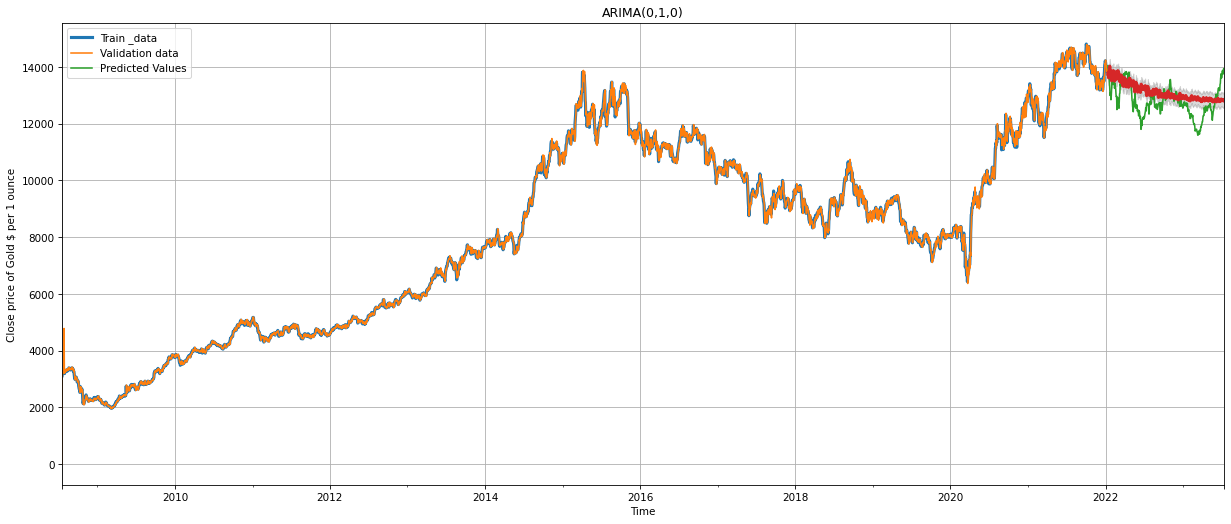

In [ ]:
## Visulaization
fig,ax= plt.subplots(figsize=(20,8))
#train1.plot(kind='line',ax =ax)
train2.plot(kind = 'line',ax =ax,linewidth=3)
fitted3_values_non.plot(kind = 'line',ax =ax)
plt.xlabel('Time')
#ARIMA(train1[3460:], order=(0,1,0)).fit().fittedvalues.plot(kind='line',ax =ax)
test['Close'].plot(kind='line',ax =ax)

##
test['Predicted_Values_SARIMA'].plot(kind='line',linewidth=3,ax=ax)
##
plt.xlabel('Time')
#plt.ylim(10000,15000)
plt.fill_between(test.index, (c3_lower),(c3_upper),alpha=0.15, color = 'black' )
plt.ylabel("Close price of Gold $ per 1 ounce")
plt.legend(['Train _data','Validation data','Predicted Values'])
plt.title('ARIMA(0,1,0)')
plt.grid()
plt.show()

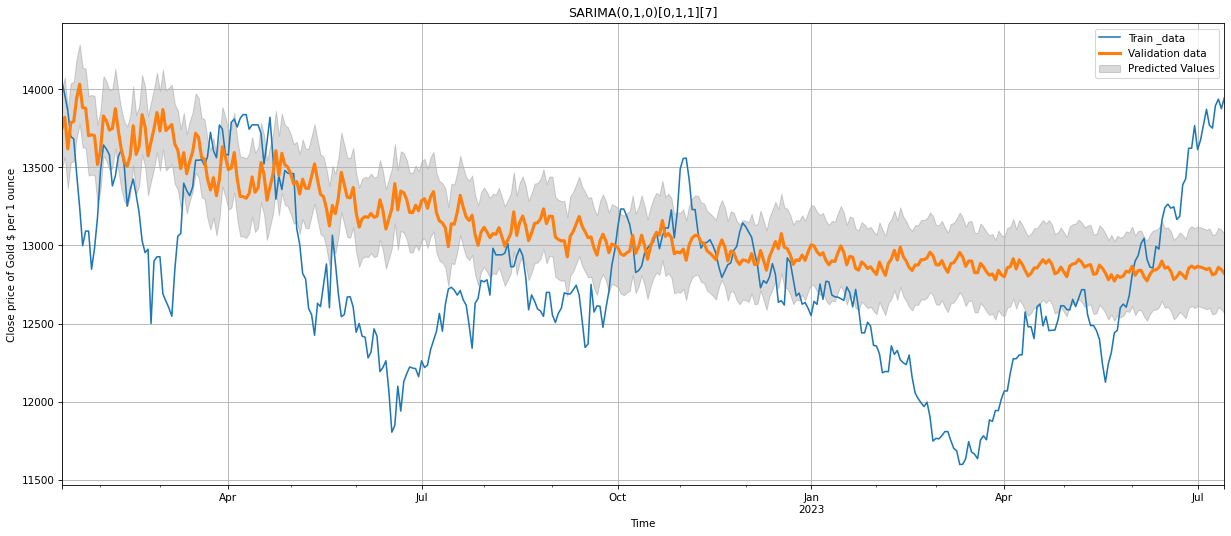

In [ ]:
fig,ax= plt.subplots(figsize=(20,8))
plt.xlabel('Time')
#ARIMA(train1[3460:], order=(0,1,0)).fit().fittedvalues.plot(kind='line',ax =ax)
test['Close'].plot(kind='line',ax =ax)

##
test['Predicted_Values_SARIMA'].plot(kind='line',linewidth=3,ax=ax)
##
plt.xlabel('Time')
#plt.ylim(10000,15000)
plt.fill_between(test.index, (c3_lower),(c3_upper),alpha=0.15, color = 'black' )
plt.ylabel("Close price of Gold $ per 1 ounce")
plt.legend(['Train _data','Validation data','Predicted Values'])
plt.title('SARIMA(0,1,0)[0,1,1][7]')
plt.grid()
plt.show()

##**Foercasting Using SARIMA model**

In [ ]:
model3_3 = SARIMAX(data['Close'], order=(1,1,0),seasonal_order=(5,1,0,8))
model_fit3_3 = model3_3.fit()
fitted_data_values=model_fit3_3.fittedvalues

In [ ]:
data['Close'].tail()

Date
2023-07-10    13751.80
2023-07-11    13895.40
2023-07-12    13936.70
2023-07-13    13876.55
2023-07-14    13945.65
Freq: B, Name: Close, dtype: float64

In [ ]:
start_foercast='2023-07-14'
end_foercast='2023-11-14'

In [ ]:

# Define the start and end dates
start_forecast = '2023-07-14'
end_forecast = '2023-11-14'

# Generate a date range using pandas.date_range()
date_range = pd.date_range(start=start_forecast, end=end_forecast, freq='B')

# Create a DataFrame with the date range as the index
time_stamp_df = pd.DataFrame(index=date_range)
time_stamp_df
data.head()





,Close
Date,
2008-07-17,3071.15
2008-07-18,3081.31
2008-07-21,3194.19
2008-07-22,3224.57
2008-07-23,3263.38


In [ ]:
test_s.tail()

,Close,"Predicted_Values_ARIMA(0,1,0)","Predicted_Values_ARIMA(4,1,3)"
Date,,,
2023-07-10,13751.80,12524.723231,12791.230493
2023-07-11,13895.40,12521.349580,12788.575661
2023-07-12,13936.70,12517.975928,12785.931863
2023-07-13,13876.55,12514.602277,12783.282196
2023-07-14,13945.65,12511.228625,12780.631679


In [ ]:
forecast_values = model_fit3_1.predict(start=start_forecast, end=end_forecast)
print(forecast_values.head())
print(test_s.iloc[-1])

2023-07-14   -25.070275
2023-07-17   -50.236221
2023-07-18    43.828910
2023-07-19   -35.131863
2023-07-20     9.172510
Freq: B, Name: predicted_mean, dtype: float64
Close                            13945.650000
Predicted_Values_ARIMA(0,1,0)    12511.228625
Predicted_Values_ARIMA(4,1,3)    12780.631679
Name: 2023-07-14 00:00:00, dtype: float64


In [ ]:
time_stamp_df['Foercasted_value'] =test_s['Close'].iloc[-1]+np.cumsum(forecast_values)
time_stamp_df.head(5)
#time_stamp_df['Foercasted_value'] = model_fit3_3.predict(start=start_foercast,end=end_foercast)
#time_stamp_df['Foercasted_value'].head()

,Foercasted_value
2023-07-14,13920.579725
2023-07-17,13870.343504
2023-07-18,13914.172414
2023-07-19,13879.040552
2023-07-20,13888.213062


In [ ]:
sd_pred = model_fit3_2.resid.std()
ME_pred = 1.96*sd_pred
c4_lower = time_stamp_df['Foercasted_value']- ME_pred
c4_upper = time_stamp_df['Foercasted_value']+ ME_pred
start_closer = pd.to_datetime('2022-04-14')
end_closer = pd.to_datetime('2023-08-14')

# Foercasted value for Nifty pharma stock

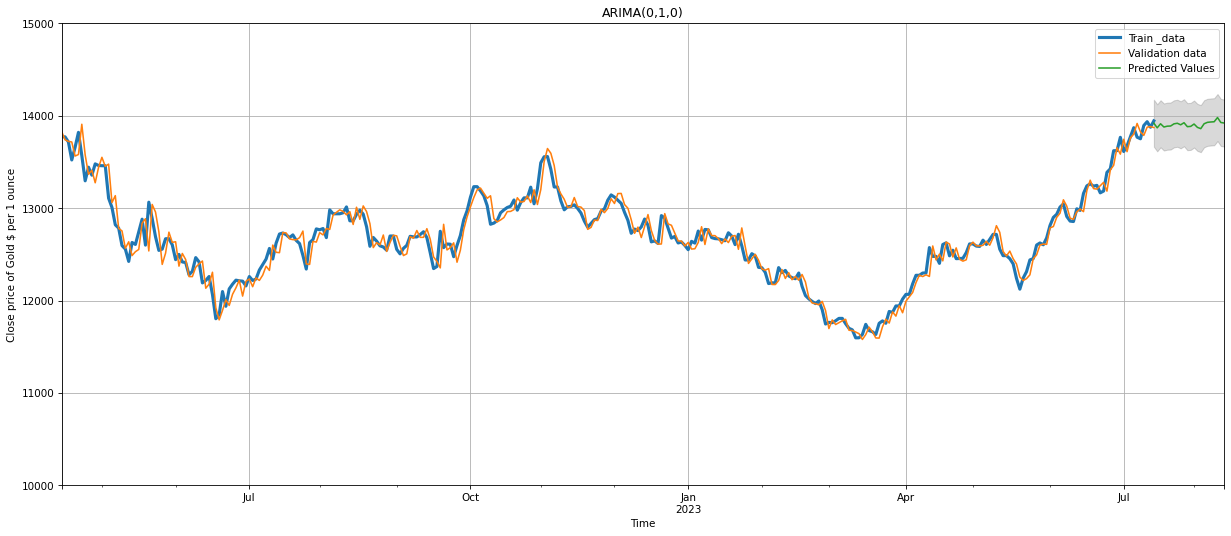

In [ ]:
fig,ax= plt.subplots(figsize=(20,8))
data['Close'].plot(kind = 'line',ax =ax,linewidth=3)
fitted_data_values.plot(kind = 'line',ax =ax)
time_stamp_df['Foercasted_value'].plot(kind='line',ax =ax)
plt.xlabel('Time')
plt.ylim(10000,15000)
plt.xlim(start_closer,end_closer)
plt.fill_between(time_stamp_df.index, (c4_lower),(c4_upper),alpha=0.15, color = 'black' )
plt.ylabel("Close price of Gold $ per 1 ounce")
plt.legend(['Train _data','Validation data','Predicted Values'])
plt.title('ARIMA(0,1,0)')
plt.grid()
plt.show()

# SARIMA Modeling